In [1]:
from transformers import BertTokenizer, BertModel
import torch

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
sentence = "Sphinx of black quartz, judge my vow."
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
# Add the special tokens.
marked_text = "[CLS] " + sentence + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

segments_ids = [1 for _ in range(len(tokenized_text))]

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]


# `hidden_states` has shape [13 x 1 x 22 x 768]
# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [16]:
hidden_states[0].shape

torch.Size([1, 11, 768])

In [31]:
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')
corpus = ["red", "blue", "green", "anger", "joy", "grass", "sunflower", "yellow"]
result = pd.DataFrame()
result["label"] = corpus
result["x"] = 0
result["y"] = 0
result["z"] = 0
result["frame"] = 2

for i in range(3, len(corpus)):

    corpus_embeddings = embedder.encode(corpus[:i], convert_to_tensor=True)
    three_dim = PCA(n_components=3, random_state=0).fit_transform(corpus_embeddings)

    df = pd.DataFrame(data=[x for x in three_dim], columns=["x", "y", "z"])
    df["label"] = corpus[:i]
    df["frame"] = i
    result = pd.concat([result, df])

# normalize
result["x"] = (result["x"] - result["x"].min()) / (result["x"].max() - result["x"].min())
result["y"] = (result["y"] - result["y"].min()) / (result["y"].max() - result["y"].min())
result["z"] = (result["z"] - result["z"].min()) / (result["z"].max() - result["z"].min())

px.scatter_3d(result, x="x", y="y", z="z", animation_frame="frame", animation_group="label",
              color="label", hover_name="label",
              range_x=[0,1], range_y=[0,1])

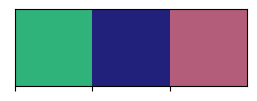

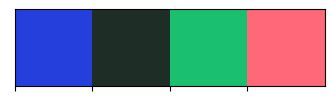

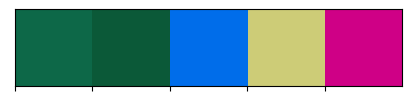

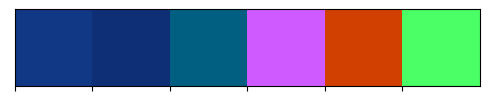

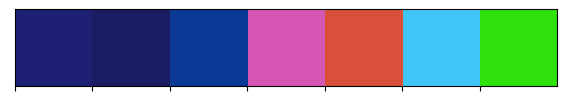

In [41]:
import seaborn as sns

for i in range(3, len(corpus)):
    sample = result[result["frame"] == i][["x", "y", "z"]]
    pal = sns.color_palette(sample.values)
    sns.palplot(pal)
    